# Import Library

In [41]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, SimpleRNN, Bidirectional, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import sys
import os

sys.path.append(os.path.abspath('../'))
from RNN.RNNFromScratch import RNNFromScratch

In [42]:
# Set a random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Load Datasets

In [43]:
try:
    train_df = pd.read_csv('../dataset/train.csv')
    valid_df = pd.read_csv('../dataset/valid.csv')
    test_df = pd.read_csv('../dataset/test.csv')
except FileNotFoundError:
    print("Directory invalid!.")
    exit()

X_train, y_train = train_df['text'], train_df['label']
X_val, y_val = valid_df['text'], valid_df['label']
X_test, y_test = test_df['text'], test_df['label']

# Text Vectorization

In [44]:
# TextVectorization
max_features = 5000 
sequence_length = 100 

vectorize_layer = TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

vectorize_layer.adapt(X_train)

In [45]:
def vectorize_text(text):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text)

X_train_vec = vectorize_text(X_train).numpy()
X_val_vec = vectorize_text(X_val).numpy()
X_test_vec = vectorize_text(X_test).numpy()

In [46]:
# Encode labels 
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

y_train_np = np.array(y_train_enc)
y_val_np = np.array(y_val_enc)
y_test_np = np.array(y_test_enc)

print(f"X_train_vec shape: {X_train_vec.shape}")
print(f"y_train_np shape: {y_train_np.shape}")
print(f"X_val_vec shape: {X_val_vec.shape}")
print(f"y_val_np shape: {y_val_np.shape}")
print(f"X_test_vec shape: {X_test_vec.shape}")
print(f"y_test_np shape: {y_test_np.shape}")

vocab_size = len(vectorize_layer.get_vocabulary())
print(f"Vocabulary size: {vocab_size}")

num_classes = len(np.unique(y_train_np))
print(f"Number of classes: {num_classes}")

X_train_vec shape: (500, 100)
y_train_np shape: (500,)
X_val_vec shape: (100, 100)
y_val_np shape: (100,)
X_test_vec shape: (400, 100)
y_test_np shape: (400,)
Vocabulary size: 2836
Number of classes: 3


# Modeling RNN From Keras

In [47]:
# f1_macro metric
def f1_macro(y_true, y_pred):
    y_pred_classes = tf.argmax(y_pred, axis=1)
    y_true_int = tf.cast(y_true, tf.int64) 
    return tf.py_function(lambda yt, yp: f1_score(yt, yp, average='macro', zero_division=0),
                          (y_true_int, y_pred_classes),
                          tf.float64)

# plot history function
def plot_history(history, title):
    plt.figure(figsize=(14, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot F1-score
    plt.subplot(1, 2, 2)
    if 'f1_macro' in history.history:
        plt.plot(history.history['f1_macro'], label='Training F1-macro')
        plt.plot(history.history['val_f1_macro'], label='Validation F1-macro')
        plt.title(f'{title} - F1-macro Score')
        plt.xlabel('Epoch')
        plt.ylabel('F1-macro Score')
        plt.legend()
        plt.grid(True)
    else:
        plt.text(0.5, 0.5, "F1-macro tidak dicatat langsung.", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()

In [48]:
# Base training parameters
embedding_dim = 256 
epochs = 10
batch_size = 32

In [49]:
# Base model creation function
def create_rnn_model(rnn_layers_config, dropout_rate=0.5): 
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=sequence_length))

    for i, (rnn_layer_type, cells) in enumerate(rnn_layers_config):
        return_sequences = (i < len(rnn_layers_config) - 1)
        if rnn_layer_type == 'simple':
            model.add(SimpleRNN(cells, return_sequences=return_sequences))
        elif rnn_layer_type == 'bidirectional_simple': 
            model.add(Bidirectional(SimpleRNN(cells, return_sequences=return_sequences)))

        model.add(Dropout(dropout_rate))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=SparseCategoricalCrossentropy(),
                  metrics=[f1_macro]) 
    return model

# Early Stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5,         
    mode='max',         
    restore_best_weights=True 
)


# 1. Pengaruh Jumlah Layer RNN


Training with 1 Bidirectional SimpleRNN layer(s)...
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_37 (Embedding)    (None, 100, 256)          726016    
                                                                 
 bidirectional_55 (Bidirect  (None, 128)               41088     
 ional)                                                          
                                                                 
 dropout_60 (Dropout)        (None, 128)               0         
                                                                 
 dense_37 (Dense)            (None, 3)                 387       
                                                                 
Total params: 767491 (2.93 MB)
Trainable params: 767491 (2.93 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
16/16 [============

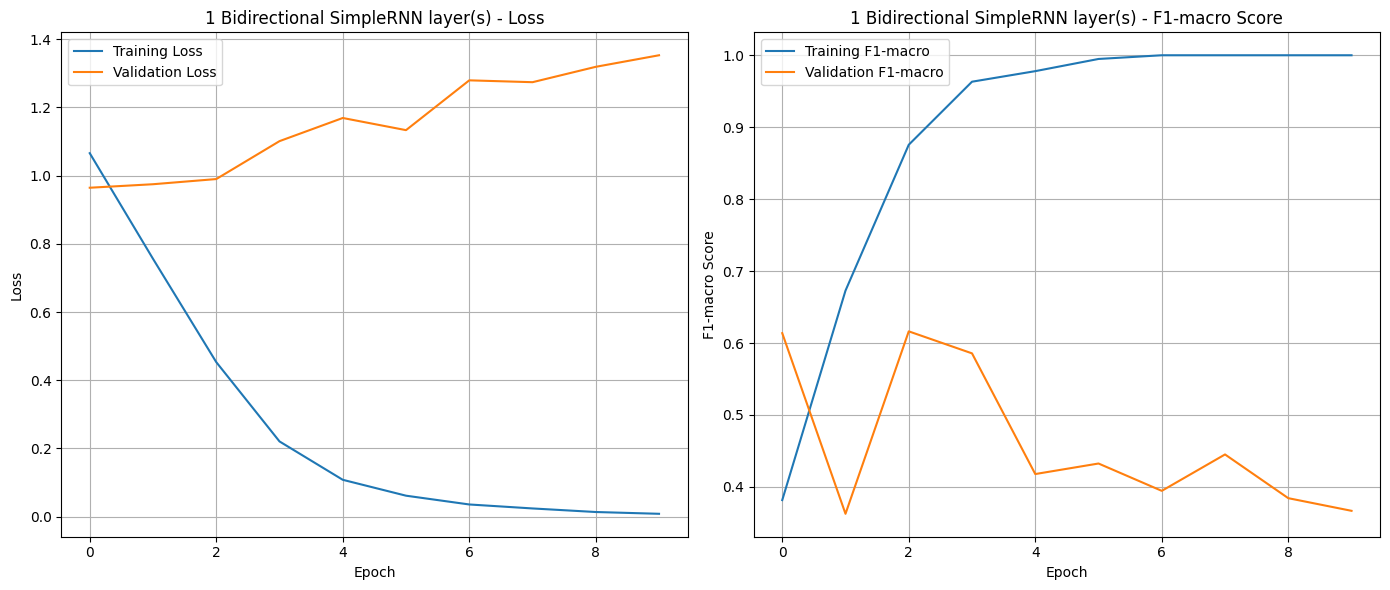


Training with 2 Bidirectional SimpleRNN layer(s)...
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_38 (Embedding)    (None, 100, 256)          726016    
                                                                 
 bidirectional_56 (Bidirect  (None, 100, 128)          41088     
 ional)                                                          
                                                                 
 dropout_61 (Dropout)        (None, 100, 128)          0         
                                                                 
 bidirectional_57 (Bidirect  (None, 128)               24704     
 ional)                                                          
                                                                 
 dropout_62 (Dropout)        (None, 128)               0         
                                                                 


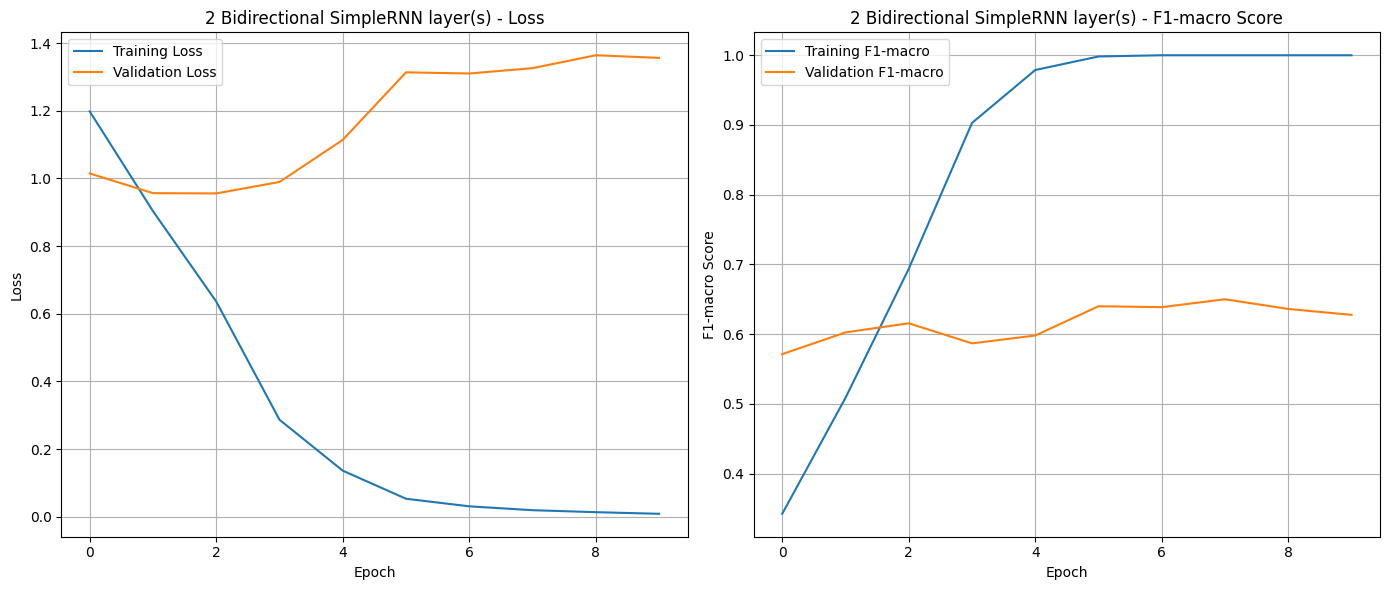


Training with 3 Bidirectional SimpleRNN layer(s)...
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_39 (Embedding)    (None, 100, 256)          726016    
                                                                 
 bidirectional_58 (Bidirect  (None, 100, 128)          41088     
 ional)                                                          
                                                                 
 dropout_63 (Dropout)        (None, 100, 128)          0         
                                                                 
 bidirectional_59 (Bidirect  (None, 100, 128)          24704     
 ional)                                                          
                                                                 
 dropout_64 (Dropout)        (None, 100, 128)          0         
                                                                 


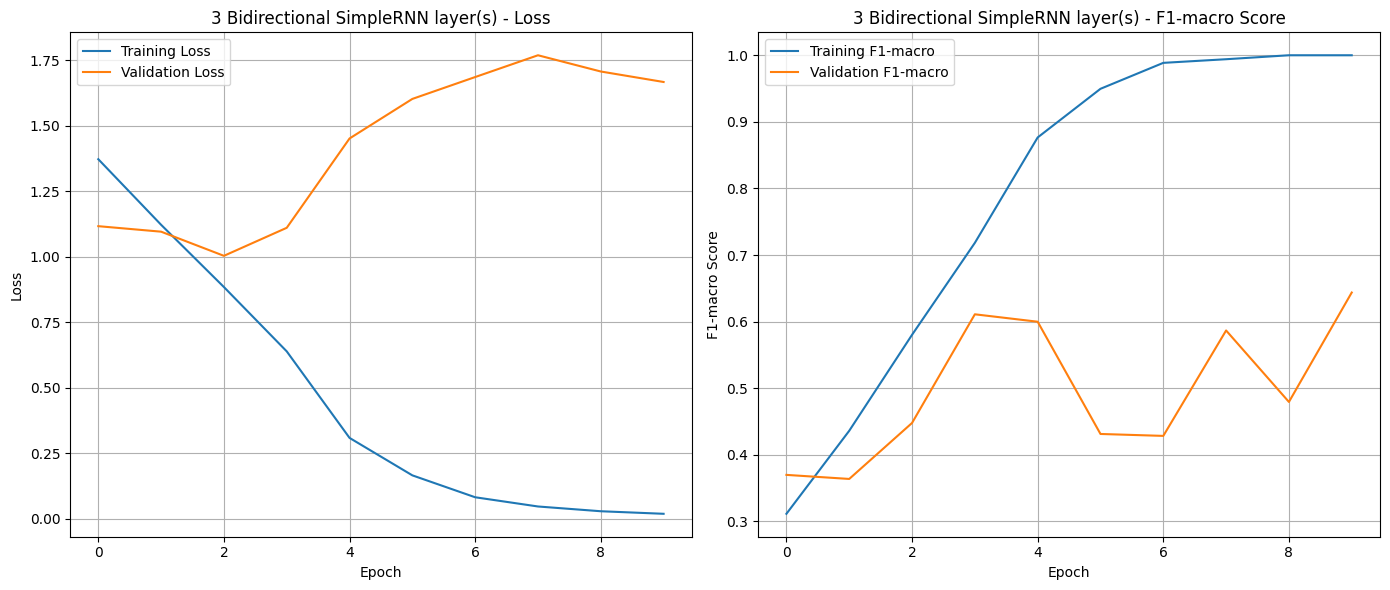


Comparison of Number of RNN Layers:
Model: num_layers_1_bidirectional_simple, Macro F1-score: 0.4541
Model: num_layers_2_bidirectional_simple, Macro F1-score: 0.5287
Model: num_layers_3_bidirectional_simple, Macro F1-score: 0.5738


In [50]:
rnn_layer_configs_num_layers = [
    [('bidirectional_simple', 64)],
    [('bidirectional_simple', 64), ('bidirectional_simple', 64)],
    [('bidirectional_simple', 64), ('bidirectional_simple', 64), ('bidirectional_simple', 64)],
]

histories_num_layers = {}
f1_scores_num_layers = {}

for i, config in enumerate(rnn_layer_configs_num_layers):
    num_layers_str = f"{len(config)} {'Bidirectional SimpleRNN' if config[0][0].startswith('bidirectional') else 'SimpleRNN'} layer(s)"
    print(f"\nTraining with {num_layers_str}...")
    model_name = f"num_layers_{len(config)}_{config[0][0]}"
    model = create_rnn_model(config)
    model.summary()
    history = model.fit(X_train_vec, y_train_np,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val_vec, y_val_np),
                        callbacks=[early_stopping],
                        verbose=1)
    histories_num_layers[model_name] = history

    y_pred_probs = model.predict(X_test_vec)
    y_pred = np.argmax(y_pred_probs, axis=1)
    macro_f1 = f1_score(y_test_np, y_pred, average='macro', zero_division=0)
    f1_scores_num_layers[model_name] = macro_f1
    print(f"Macro F1-score for {num_layers_str}: {macro_f1:.4f}")

    plot_history(history, f"{num_layers_str}")

print("\nComparison of Number of RNN Layers:")
for name, f1 in f1_scores_num_layers.items():
    print(f"Model: {name}, Macro F1-score: {f1:.4f}")

# 2. Pengaruh Banyak Cell RNN per Layer


Training with Bidirectional SimpleRNN with 32 cells...
Model: "sequential_173"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_173 (Embedding)   (None, 100, 256)          726016    
                                                                 
 bidirectional_193 (Bidirec  (None, 64)                18496     
 tional)                                                         
                                                                 
 dropout_199 (Dropout)       (None, 64)                0         
                                                                 
 dense_173 (Dense)           (None, 3)                 195       
                                                                 
Total params: 744707 (2.84 MB)
Trainable params: 744707 (2.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
16/16 [========

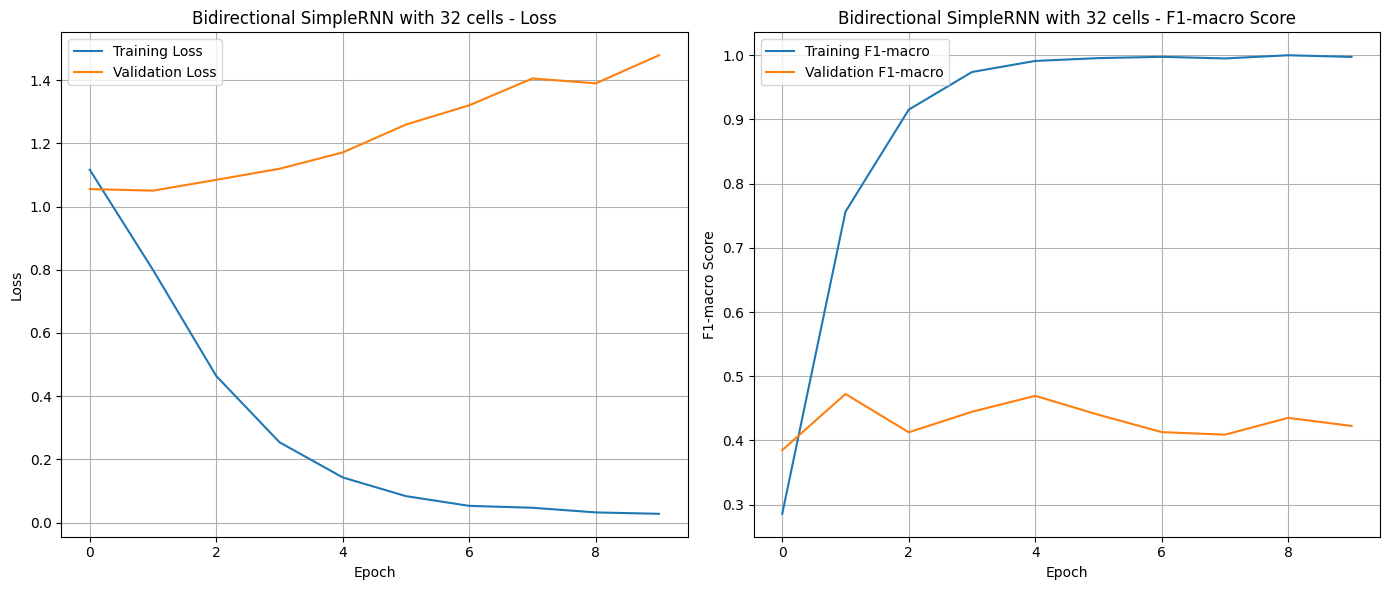


Training with Bidirectional SimpleRNN with 64 cells...
Model: "sequential_174"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_174 (Embedding)   (None, 100, 256)          726016    
                                                                 
 bidirectional_194 (Bidirec  (None, 128)               41088     
 tional)                                                         
                                                                 
 dropout_200 (Dropout)       (None, 128)               0         
                                                                 
 dense_174 (Dense)           (None, 3)                 387       
                                                                 
Total params: 767491 (2.93 MB)
Trainable params: 767491 (2.93 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
16/16 [========

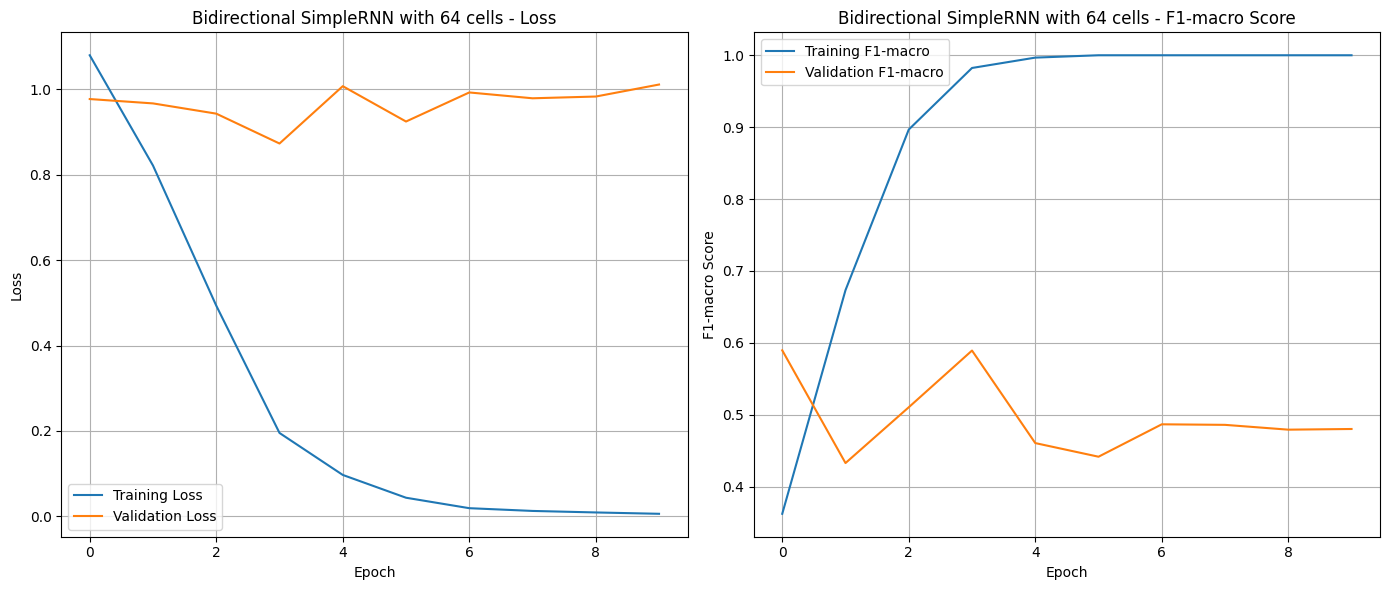


Training with Bidirectional SimpleRNN with 128 cells...
Model: "sequential_175"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_175 (Embedding)   (None, 100, 256)          726016    
                                                                 
 bidirectional_195 (Bidirec  (None, 256)               98560     
 tional)                                                         
                                                                 
 dropout_201 (Dropout)       (None, 256)               0         
                                                                 
 dense_175 (Dense)           (None, 3)                 771       
                                                                 
Total params: 825347 (3.15 MB)
Trainable params: 825347 (3.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
16/16 [=======

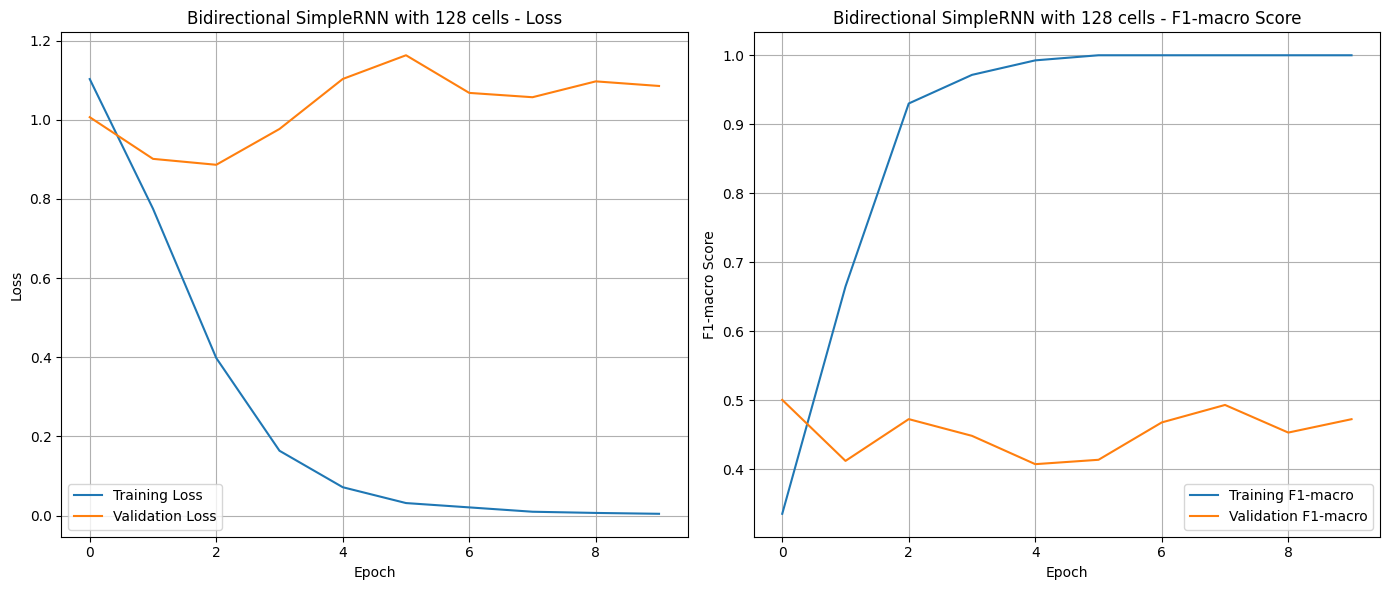


Comparison of Number of RNN Cells per Layer:
Model: num_cells_32, Macro F1-score: 0.4561
Model: num_cells_64, Macro F1-score: 0.5178
Model: num_cells_128, Macro F1-score: 0.5039


In [96]:
rnn_layer_configs_num_cells = [
    [('bidirectional_simple', 32)], 
    [('bidirectional_simple', 64)], 
    [('bidirectional_simple', 128)], 
]

histories_num_cells = {}
f1_scores_num_cells = {}

for i, config in enumerate(rnn_layer_configs_num_cells):
    num_cells_str = f"Bidirectional SimpleRNN with {config[0][1]} cells"
    print(f"\nTraining with {num_cells_str}...")
    model_name = f"num_cells_{config[0][1]}"
    model = create_rnn_model(config)
    model.summary()
    history = model.fit(X_train_vec, y_train_np,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val_vec, y_val_np),
                        callbacks=[early_stopping],
                        verbose=1)
    histories_num_cells[model_name] = history

    y_pred_probs = model.predict(X_test_vec)
    y_pred = np.argmax(y_pred_probs, axis=1)
    macro_f1 = f1_score(y_test_np, y_pred, average='macro', zero_division=0)
    f1_scores_num_cells[model_name] = macro_f1
    print(f"Macro F1-score for {num_cells_str}: {macro_f1:.4f}")

    plot_history(history, f"{num_cells_str}")

print("\nComparison of Number of RNN Cells per Layer:")
for name, f1 in f1_scores_num_cells.items():
    print(f"Model: {name}, Macro F1-score: {f1:.4f}")

# 3. Pengaruh Jenis Layer RNN Berdasarkan Arah


Training with Unidirectional SimpleRNN...
Model: "sequential_180"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_180 (Embedding)   (None, 100, 256)          726016    
                                                                 
 simple_rnn_206 (SimpleRNN)  (None, 128)               49280     
                                                                 
 dropout_206 (Dropout)       (None, 128)               0         
                                                                 
 dense_180 (Dense)           (None, 3)                 387       
                                                                 
Total params: 775683 (2.96 MB)
Trainable params: 775683 (2.96 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
16/16 [==============================] - 2s 47ms/step - loss: 1.1077 - f1_macro: 0.2698 - val_

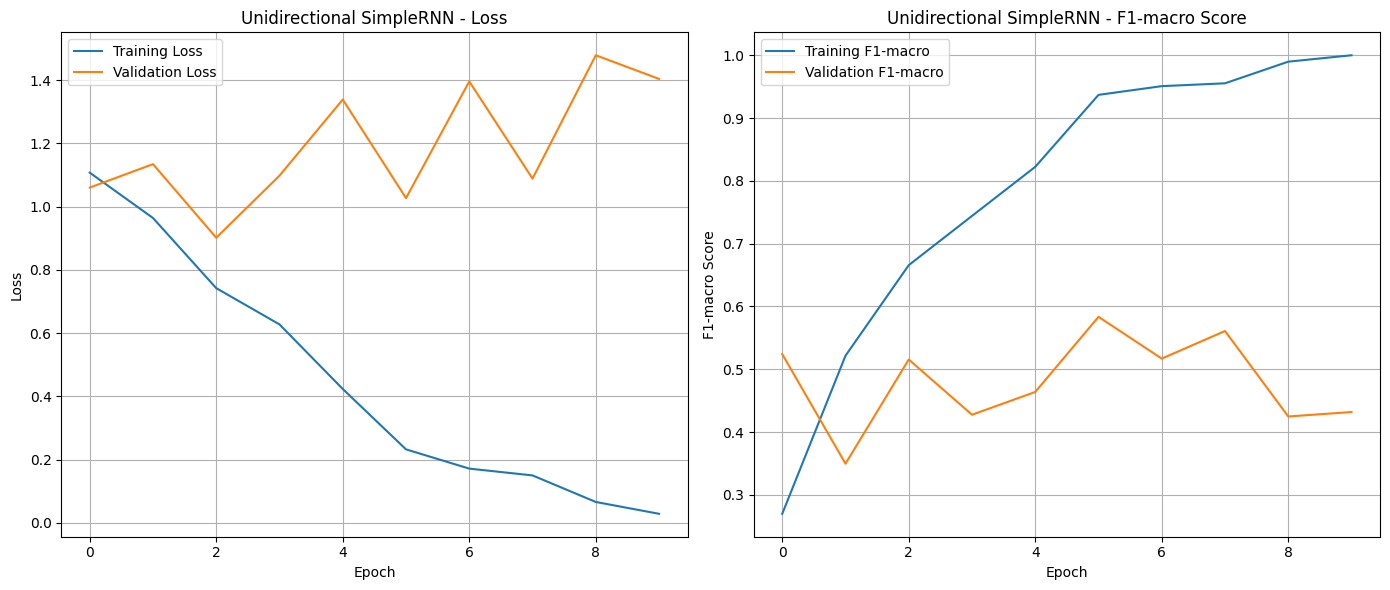


Training with Bidirectional SimpleRNN...
Model: "sequential_181"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_181 (Embedding)   (None, 100, 256)          726016    
                                                                 
 bidirectional_198 (Bidirec  (None, 256)               98560     
 tional)                                                         
                                                                 
 dropout_207 (Dropout)       (None, 256)               0         
                                                                 
 dense_181 (Dense)           (None, 3)                 771       
                                                                 
Total params: 825347 (3.15 MB)
Trainable params: 825347 (3.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
16/16 [======================

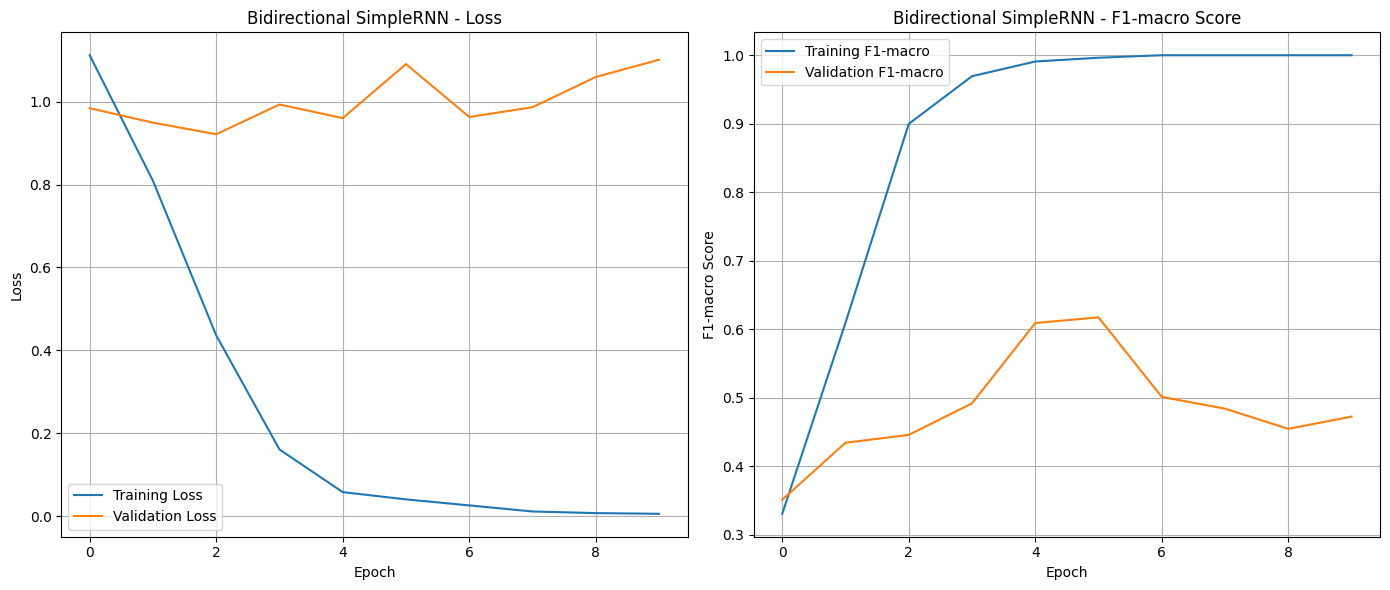


Comparison of RNN Layer Direction:
Model: direction_simple, Macro F1-score: 0.4745
Model: direction_bidirectional_simple, Macro F1-score: 0.5416


In [99]:
rnn_layer_configs_direction = [
    [('simple', 128)],             
    [('bidirectional_simple', 128)], 
]

histories_direction = {}
f1_scores_direction = {}

for i, config in enumerate(rnn_layer_configs_direction):
    direction_type_str = "Unidirectional SimpleRNN" if config[0][0] == 'simple' else "Bidirectional SimpleRNN"
    print(f"\nTraining with {direction_type_str}...")
    model_name = f"direction_{config[0][0]}"
    model = create_rnn_model(config)
    model.summary()
    history = model.fit(X_train_vec, y_train_np,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val_vec, y_val_np),
                        callbacks=[early_stopping],
                        verbose=1)
    histories_direction[model_name] = history

    y_pred_probs = model.predict(X_test_vec)
    y_pred = np.argmax(y_pred_probs, axis=1)
    macro_f1 = f1_score(y_test_np, y_pred, average='macro', zero_division=0)
    f1_scores_direction[model_name] = macro_f1
    print(f"Macro F1-score for {direction_type_str}: {macro_f1:.4f}")

    plot_history(history, f"{direction_type_str}")

print("\nComparison of RNN Layer Direction:")
for name, f1 in f1_scores_direction.items():
    print(f"Model: {name}, Macro F1-score: {f1:.4f}")

# 4. Forward Propagation: Keras Vs From Scratch

In [13]:
# Create final model
final_config = [('simple', 128), ('simple', 128), ('bidirectional_simple', 128)]
final_model = create_rnn_model(final_config)

final_model.summary()

# Train final model
print("\nTraining Final Model...")
final_keras_history = final_model.fit(X_train_vec, y_train_np,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val_vec, y_val_np),
                    callbacks=[early_stopping],
                    verbose=1)

# Evaluate final model
y_pred_probs = final_model.predict(X_test_vec)
y_pred = np.argmax(y_pred_probs, axis=1)
final_macro_f1 = f1_score(y_test_np, y_pred, average='macro', zero_division=0)
print(f"\nFinal Model Macro F1-score: {final_macro_f1:.4f}")

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 100, 256)          726016    
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, 100, 128)          49280     
                                                                 
 dropout_11 (Dropout)        (None, 100, 128)          0         
                                                                 
 simple_rnn_12 (SimpleRNN)   (None, 100, 128)          32896     
                                                                 
 dropout_12 (Dropout)        (None, 100, 128)          0         
                                                                 
 bidirectional_10 (Bidirect  (None, 256)               65792     
 ional)                                                          
                                                      

In [101]:
print("\nSaving Model...")
final_model.save('output_model/rnn_model.h5')
print("Model saved successfully!")


Saving Model...
Model saved successfully!


In [102]:
# Load saved Keras model
loaded_keras_model = tf.keras.models.load_model('output_model/rnn_model.h5', 
                                               custom_objects={'f1_macro': f1_macro})

# Initialize from scratch model
rnn_scratch = RNNFromScratch()
rnn_scratch.load_keras_model(loaded_keras_model)


Loading Keras model into RNNFromScratch...

Model loaded successfully. 
8 layers:
Layer 1: EmbeddingLayer
Layer 2: SimpleRNNLayer
Layer 3: DropoutLayer
Layer 4: SimpleRNNLayer
Layer 5: DropoutLayer
Layer 6: BidirectionalRNNLayer
Layer 7: DropoutLayer
Layer 8: DenseLayer


In [103]:
print("\n" + "="*50)
print("FORWARD PROPAGATION: KERAS VS FROM SCRATCH MODELS")
print("="*50)

keras_pred_probs_full = loaded_keras_model.predict(X_test_vec, verbose=0)
keras_pred_full = np.argmax(keras_pred_probs_full, axis=1)
keras_f1_full = f1_score(y_test_np, keras_pred_full, average='macro', zero_division=0)

scratch_pred_probs_full = rnn_scratch.predict(X_test_vec, batch_size=64)
scratch_pred_full = np.argmax(scratch_pred_probs_full, axis=1)
scratch_f1_full = f1_score(y_test_np, scratch_pred_full, average='macro', zero_division=0)

print(f"\nFull Test Set Results:")
print(f"Keras F1-score: {keras_f1_full:.6f}")
print(f"From Scratch F1-score: {scratch_f1_full:.6f}")

print(f"\nDifference: {abs(keras_f1_full - scratch_f1_full):.6f}")
prob_diff_full = np.mean(np.abs(keras_pred_probs_full - scratch_pred_probs_full))
print(f"Average probability difference: {prob_diff_full:.6f}")


FORWARD PROPAGATION: KERAS VS FROM SCRATCH MODELS

Full Test Set Results:
Keras F1-score: 0.613340
From Scratch F1-score: 0.613340

Difference: 0.000000
Average probability difference: 0.000000


# 5. Keras Vs From Scratch Model

In [126]:
rnn_final_scratch = RNNFromScratch(learning_rate=0.001)

rnn_final_scratch.add_embedding_layer(vocab_size, embedding_dim)

rnn_final_scratch.add_simple_rnn_layer(units=128, return_sequences=True)
rnn_final_scratch.add_dropout_layer(0.5)

rnn_final_scratch.add_simple_rnn_layer(units=128, return_sequences=True)
rnn_final_scratch.add_dropout_layer(0.5)

rnn_final_scratch.add_bidirectional_rnn_layer(units=64, return_sequences=False) 
rnn_final_scratch.add_dropout_layer(0.5)

rnn_final_scratch.add_dense_layer(units=num_classes, activation='softmax')


In [127]:
print("\nTraining Final Scratch Model...")
final_scratch_history = rnn_final_scratch.fit(
    X_train_vec, y_train_np,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val_vec, y_val_np),
    verbose=1
)


Training Final Scratch Model...
Epoch 1/10 - loss: 1.3727 - f1: 0.3582 - val_loss: 1.2057 - val_f1: 0.2627
Epoch 2/10 - loss: 1.4680 - f1: 0.2935 - val_loss: 1.1569 - val_f1: 0.2796
Epoch 3/10 - loss: 1.5017 - f1: 0.2859 - val_loss: 1.1339 - val_f1: 0.2477
Epoch 4/10 - loss: 1.3700 - f1: 0.3478 - val_loss: 1.1404 - val_f1: 0.2782
Epoch 5/10 - loss: 1.4023 - f1: 0.3248 - val_loss: 1.1371 - val_f1: 0.2611
Epoch 6/10 - loss: 1.3827 - f1: 0.3556 - val_loss: 1.1329 - val_f1: 0.2882
Epoch 7/10 - loss: 1.3377 - f1: 0.3505 - val_loss: 1.1561 - val_f1: 0.2783
Epoch 8/10 - loss: 1.3662 - f1: 0.3209 - val_loss: 1.1480 - val_f1: 0.2698
Epoch 9/10 - loss: 1.4101 - f1: 0.3231 - val_loss: 1.1484 - val_f1: 0.2611
Epoch 10/10 - loss: 1.3713 - f1: 0.3323 - val_loss: 1.1692 - val_f1: 0.2958


In [128]:
scratch_preds = rnn_final_scratch.predict(X_test_vec)
scratch_preds_argmax = np.argmax(scratch_preds, axis=1)
scratch_macro_f1 = f1_score(y_test_np, scratch_preds_argmax, average='macro', zero_division=0)
print(f"\nFinal Scratch Model Macro F1-score: {scratch_macro_f1:.4f}")


Final Scratch Model Macro F1-score: 0.3222


In [129]:
print("\n=== FINAL COMPARISON ===")
print(f"Keras Final Model Macro F1 : {final_macro_f1:.4f}")
print(f"Scratch Final Model Macro F1 : {scratch_macro_f1:.4f}")



=== FINAL COMPARISON ===
Keras Final Model Macro F1 : 0.6133
Scratch Final Model Macro F1 : 0.3222



Plotting Final Keras Model History...


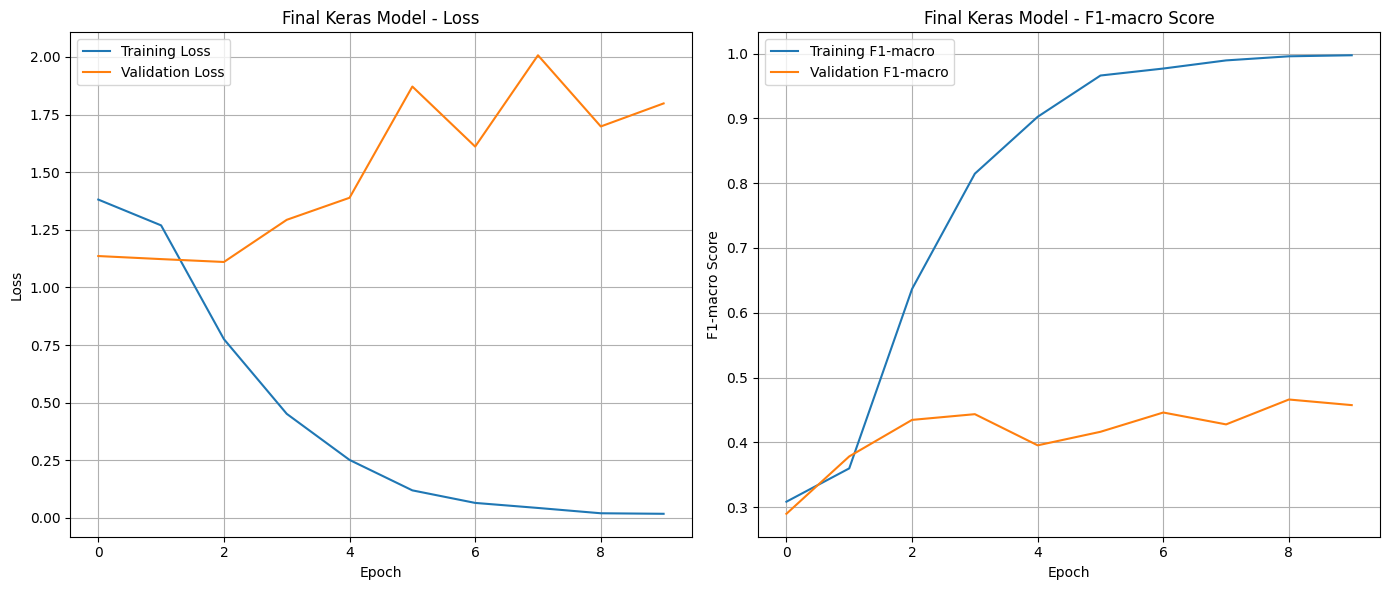

In [130]:
print("\nPlotting Final Keras Model History...")
plot_history(final_keras_history, "Final Keras Model")


Plotting Final Scratch Model History...


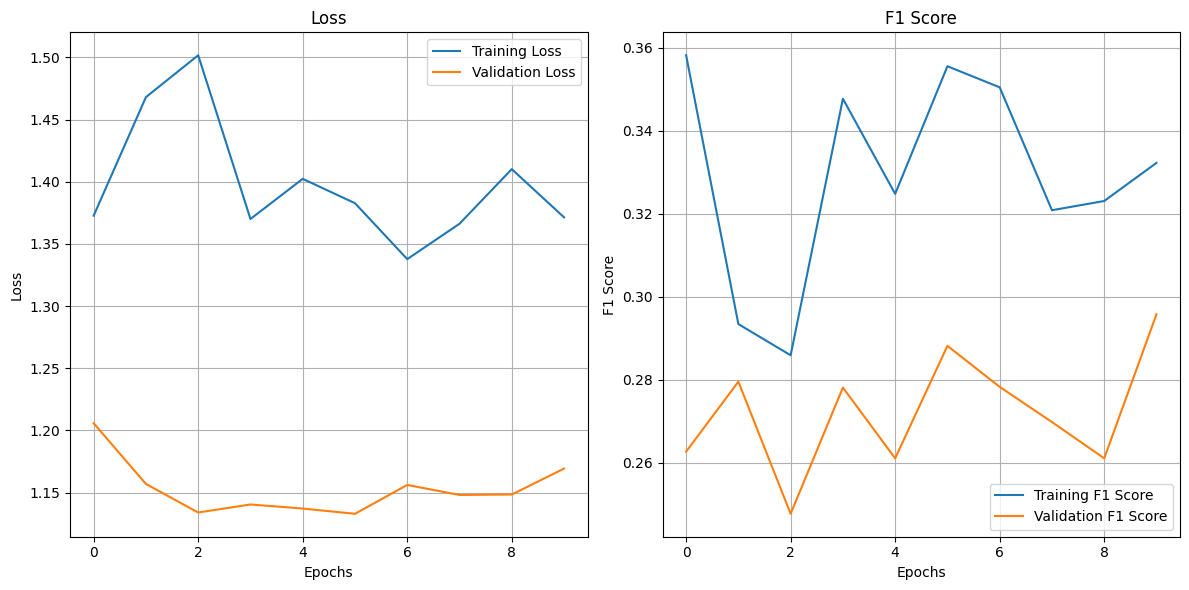

In [131]:
print("\nPlotting Final Scratch Model History...")
rnn_final_scratch.plot_history(final_scratch_history)